In [75]:
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage,ToolMessage,SystemMessage,HumanMessage,AIMessage
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from pathlib import Path
import os

In [84]:
dotenv_path = Path('.env')
load_dotenv(dotenv_path=dotenv_path)
api_key=os.getenv("deepseekkey")
# api_key=os.getenv("gptAPIKEY")
# print(api_key)

In [85]:
class Agent(TypedDict):
    message : Annotated[Sequence[BaseMessage], add_messages]

In [86]:
filecontents=""
with open("events.txt",'a+') as file:
    file.seek(0)
    filecontents=(file.read())
filecontents

''

In [87]:
@tool
def saveevent(content:str)->str:
    """save the contents to a text file """
    with open("events.txt",'a+') as file:
        file.write(content)
    return "contents has been sucessfully been saved in events.txt"
@tool
def savecontent(content:str)->str:
    """save the contents to a text file """
    with open("contents.txt",'w+') as file:
        file.write(content)
    return "contents has been sucessfully been saved in events.txt"

@tool
def date():
    "returns today's date"
    from datetime import date
    return date.today()

tools = [saveevent,savecontent,date] 

In [88]:
# model= ChatOpenAI(model="z-ai/glm-4.5-air:free",api_key=api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools)

model= ChatOpenAI(model="deepseek/deepseek-chat-v3-0324:free",api_key=api_key,base_url="https://openrouter.ai/api/v1").bind_tools(tools=tools)

In [ ]:
test=[]
def process(state: Agent) -> Agent:
    system_prompt = SystemMessage(content=f"""
    You are a scheduling assistant.
    Output ONLY in JSON format:
    {{
        "event": "...",
        "date-time": "D/M/Y-H:M",
        "priority": "high|medium|low"
    }}
    the contents of this conversation are {filecontents}    
    """)
    
    user_input = HumanMessage(content=input("Enter your task: "))
    final_messages = [system_prompt, user_input]
    
    response = model.invoke(final_messages)  # no `input=...`
    
    global test
    test.append(response.content)

    print("Full Response:", response)

    if isinstance(response, AIMessage):
        print("AI says:", response.content)
        return {"message": [response]}
    else:
        print("Unexpected response type:", type(response))
        return {"message": []}

In [90]:
graph=StateGraph(Agent)
graph.add_node("user",process)
graph.set_entry_point("user")
graph.add_edge("user",END)
app=graph.compile()

In [91]:
# son's birthday tomorrow  
app.invoke({'message':''})

Full Response: content='json\n{\n    "event": "Son\'s birthday",\n    "date-time": "12/12/2023-00:00",\n    "priority": "high"\n}\n' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 311, 'total_tokens': 351, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek/deepseek-chat-v3-0324:free', 'system_fingerprint': None, 'id': 'gen-1754845207-RdF38Sj6tEnUmXlSZ598', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--69e5b465-0d8f-4bd1-aba9-83d7d941a08a-0' usage_metadata={'input_tokens': 311, 'output_tokens': 40, 'total_tokens': 351, 'input_token_details': {}, 'output_token_details': {}}
AI says: json
{
    "event": "Son's birthday",
    "date-time": "12/12/2023-00:00",
    "priority": "high"
}



{'message': [HumanMessage(content='', additional_kwargs={}, response_metadata={}, id='5501188d-b370-4153-809f-c28bdb20f3fa'),
  AIMessage(content='json\n{\n    "event": "Son\'s birthday",\n    "date-time": "12/12/2023-00:00",\n    "priority": "high"\n}\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 311, 'total_tokens': 351, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'deepseek/deepseek-chat-v3-0324:free', 'system_fingerprint': None, 'id': 'gen-1754845207-RdF38Sj6tEnUmXlSZ598', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--69e5b465-0d8f-4bd1-aba9-83d7d941a08a-0', usage_metadata={'input_tokens': 311, 'output_tokens': 40, 'total_tokens': 351, 'input_token_details': {}, 'output_token_details': {}})]}

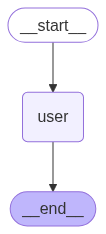

In [93]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))